# Project workshop #2: Hand Guestures Recognition!

Hey guys, we are actually building something neat from scratch level this time!
This time we are not aiming to build something that is prebuilt, but instead we are trying to create something that is from the model level. To be specific, we are building a CNN classification algorithm that could classify some simple American Hand Gesture Language.

![sign.png](https://www.lifeprint.com/asl101/fingerspelling/images/signlanguageabc.jpg)

## Import

First just get your library ready, running the below cell should be sufficient. Notice that you would need to install torch and tqdm first if you are running this on your local machine.


In [ ]:
import os
import time
import torch
import numpy as np
import torch.nn as nn
from tqdm.auto import tqdm
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler

!git clone https://github.com/UTMIST/2022-2023-Projects-Workshop.git

fatal: destination path '2022-2023-Projects-Workshop' already exists and is not an empty directory.


## Data preprocessing

First load your data in the zip folder named `img`.  The `img` data sets which is constructed with 9 folders which each contains 833-865 sets of image data (see figure for the detail class compositions). Considering the total dataset size is not relatively large, it would be ideal if most of the data is used for image training instead of model evaluations/ parameter tuning. Therefore, think about what train-validation-test spilt could be in this case :)

In [ ]:
def print_folder_structure(directory):
    """ Printing original structure of the folder
    and returns the number of images contained in each folder as a list.

    Args:
        directory: A string of home directory path that contains
                    the unzipped image data files
`
    Returns:
        count_list: A list of integers that are the number of images contained
                    in each class subfolder

    """
    total = 0
    count_list = []
    for folder in os.listdir(directory):
        count = 0
        f_path = os.path.join(directory, folder)
        for file in os.listdir(f_path):
            count += 1

        print(folder, " ", count)
        total += count
        count_list.append(count)

    print("Total: ", total)
    return count_list


def data_loader(data_folder, class_num, batch_size):
    """ Loads images data, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.
    Args:
        data_folder: torchvision.datasets.ImageFolder type that contains all datasets.
        class_num: A list contains number of sample sizes of each sign class
        batch_size: A int representing the number of samples per batch

    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size

    """
    train_indices, val_indices, test_indices = [], [], []
    count = 0
    for i in class_num:
        train_indices.extend(list(range(count, count + int(i * 0.7))))
        val_indices.extend(list(range(count + int(i * 0.7), count + int(i * 0.85))))
        test_indices.extend(list(range(count + int(i * 0.85), count + i)))
        # print(data_folder[i+count-1][1]) # for checking the end of each folder
        count += i

    np.random.seed(1000)
    np.random.shuffle(train_indices)

    train_sampler = SubsetRandomSampler(train_indices)
    train_loader_ = torch.utils.data.DataLoader(data_folder, batch_size=batch_size, num_workers=1,
                                                sampler=train_sampler)
    val_sampler = SubsetRandomSampler(val_indices)
    val_loader_ = torch.utils.data.DataLoader(data_folder, batch_size=batch_size, num_workers=1, sampler=val_sampler)
    test_sampler = SubsetRandomSampler(test_indices)
    test_loader_ = torch.utils.data.DataLoader(data_folder, batch_size=batch_size, num_workers=1, sampler=test_sampler)

    return train_loader_, val_loader_, test_loader_


def data_visualizer(train_loader_, title, start=0, end=15):
    """ Loads images data loaders and plots the first 15 images of the data loader.
    This is for checking purpose.

    Args:
        train_loader_: iterable training dataset organized according to batch size
        title: string that is the title of the resulting plots
    """

    plt.figure()
    counter = 0
    img_count = 0
    for images, labels in train_loader_:
        if counter >= start:
          # since batch_size = 1, there is only 1 image in `images`
          image = images[0]
          # place the colour channel at the end, instead of at the beginning
          img = np.transpose(image, [1, 2, 0])
          # normalize pixel intensity values to [0, 1]
          img = img / 2 + 0.5
          plt.subplot(3, 5, img_count + 1)
          plt.suptitle(title)
          plt.axis('off')
          plt.imshow(img)
          
          img_count += 1

        counter += 1
        if counter >= end:
            break

A   865
B   848
D   847
G   833
F   842
E   841
I   841
C   843
H   836
Total:  7596


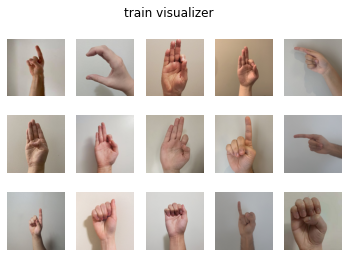

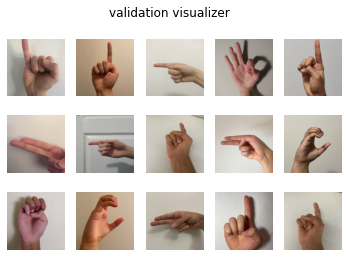

In [ ]:
%matplotlib inline
# path to the root folder that contains all structures
# dir = "..."
directory = "/content/2022-2023-Projects-Workshop/Workshop_4/img"

# see original folder structure and get according number of image classes
count_l = print_folder_structure(directory)

# The output of torchvision datasets are PILImage images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1].
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
data_folder = ImageFolder(directory, transform=transform)

train_loader, val_loader, test_loader = data_loader(data_folder, count_l, 1)
data_visualizer(train_loader, "train visualizer")
data_visualizer(val_loader, "validation visualizer")

## Build ur model

Build a convolutional neural network model that takes the (224x224 RGB) image as input, and predicts the gesture letter. Your model should be a subclass of nn.Module.

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.name = "SimpleCNN"
        self.conv1 = nn.Conv2d(3, 5, 5,stride=3,padding=0)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5,stride=2,padding=0)
        self.pool2 = nn.MaxPool2d(stride=3, kernel_size=2)
        self.fc1 = nn.Linear(6* 6 * 10, 32)
        self.fc2 = nn.Linear(32, 9)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 6 * 6 * 10)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Build your training loops

build your training codes that can train your model using user-defined parameters

In [ ]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "models/model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path


def train(model, train_loader,val_loader, batch_size=64, l_r=0.01, num_epochs=1, use_cuda=True):
    torch.manual_seed(1000)
    criterion = nn.CrossEntropyLoss()
    # Using Stochastic Gradient Descent compared to Adam
    optimizer = optim.SGD(model.parameters(), lr=l_r, momentum=0.9)  # momentum to overcome resist to change

    iters, epoch_itr, losses, val_loss, train_acc, val_acc = [], [], [], [], [], []

    # training
    n = 0 # the number of iterations

    progress_total = num_epochs * len(train_loader)
    pbar = tqdm(desc = 'while loop', total = progress_total)
    pbar.update(1)
    pbar.update(1)

    start_time = time.time()
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):

            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################


            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)

            # compute *average* loss
            ###########################################
            # get_accuracy
            pred = out.max(1,keepdim = True)[1]
            correct = pred.eq(labels.view_as(pred)).sum().item()
            total = imgs.shape[0]
            t_acc = correct/ total
            # print(t_acc)
            train_acc.append(t_acc) # compute training accuracy

            #
            #
            # v_acc = get_accuracy(model, val_imgs,val_labels)
            # val_acc.append(v_acc)  # compute validation accuracy
            n += 1
            pbar.update(1)
            # print(n/progress_total*100, "% of the training is completed")
        ##################################################################
        val_l = 0
        correct = 0
        total = 0
        for valimgs, vallabels in val_loader:


            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              valimgs = valimgs.cuda()
              vallabels = vallabels.cuda()
            #############################################

            output = model(valimgs)
            pred = output.max(1, keepdim=True)[1]
            val_l += criterion(output, vallabels).item()  # compute the total loss
            optimizer.zero_grad()
            correct += pred.eq(vallabels.view_as(pred)).sum().item()
            total += valimgs.shape[0]

        v_acc, v_loss = correct / total, float(val_l)/total
        ##################################################################
        val_acc.append(v_acc)  # compute validation accuracy
        val_loss.append(v_loss)
        epoch_itr.append(n)

        model_path = get_model_name(model.name, batch_size, l_r, epoch)
        # print(model_path)
        torch.save(model.state_dict(), model_path)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds\n".format(elapsed_time))

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.plot(epoch_itr, val_loss, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(epoch_itr, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

## Training

Train the model now.

In [ ]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [ ]:
# ======================================================
# path to the root folder
# dir = "..."
directory = "/content/2022-2023-Projects-Workshop/Workshop_4/img/"
# see original folder structure and get according number of image classes
print("#############################################")
count_l = print_folder_structure(directory)
print("#############################################")
# The output of torchvision datasets are PILImage images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1].
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


def run_cnn(nn_model, bs=64, num_e=30, lr=0.05, cuda=True):
    data_folder = ImageFolder(directory, transform=transform)
    train_loader, val_loader, test_loader = data_loader(data_folder, count_l, batch_size=bs)
    if cuda and torch.cuda.is_available():
        nn_model.cuda()
        print('CUDA is available!  Training on GPU ...\n')
    else:
        print('CUDA is not available.  Training on CPU ...\n')
    #proper model
    train(nn_model, train_loader, val_loader, l_r=lr, batch_size=bs, num_epochs=num_e)

#############################################
A   865
B   848
D   847
G   833
F   842
E   841
I   841
C   843
H   836
Total:  7596
#############################################


CUDA is not available.  Training on CPU ...



while loop:   0%|          | 0/1260 [00:00<?, ?it/s]

Total time elapsed: 466.54 seconds



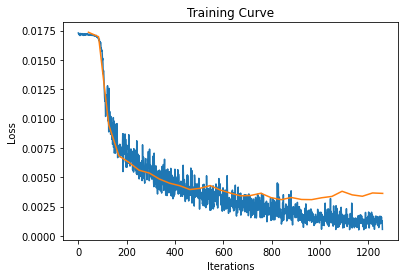

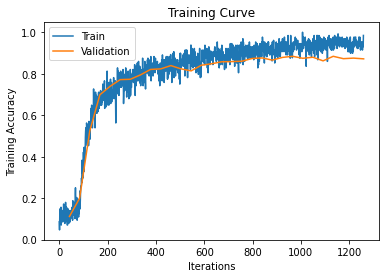

Final Training Accuracy: 0.9846153846153847
Final Validation Accuracy: 0.8717047451669596


In [ ]:
%matplotlib inline
run_cnn(SimpleCNN(), bs = 128, num_e= 30, lr= 0.01, cuda=True)

## Test your model

Remember the testing set? Try using your test data_loader to test the performance of your model.

In [ ]:
data_folder = ImageFolder(directory, transform=transform)
train_loader, val_loader, test_loader = data_loader(data_folder, count_l, batch_size=128)
net = SimpleCNN()
net.load_state_dict(torch.load('model_SimpleCNN_bs128_lr0.01_epoch29'))

<All keys matched successfully>

In [ ]:
correct = 0
total = 0
for testimgs, testlabels in test_loader:
    output = net(testimgs)
    pred = output.max(1, keepdim=True)[1]
    correct += pred.eq(testlabels.view_as(pred)).sum().item()
    total += testimgs.shape[0]

test_acc = correct / total
print("The test accuracy for the best model is {}%".format(test_acc*100))

The test accuracy for the best model is 88.64628820960698%
